![Img](https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg)

# Spaceship Titanic Competition

Kaggle's Spaceship Titanic Competion is aimed to predict if a passenger remained in this dimension or not when the *Spaceship Titanic* collided with a spacetime anomaly hidden within a dust cloud. In this notebook, I propose a data preprocessing pipeline and a neural network for the binary classification task.

## Libraries installation

In [1]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
from keras import Sequential
from keras.layers import Dense, Dropout

## Data loading

In [2]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

Let's take a look at the shapes of the datasets. As we can see, approximately one third of data is reserved to test.

In [3]:
train.shape

(8693, 14)

In [4]:
test.shape

(4277, 13)

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Exploratory Data Analysis

We will have to deal with null values in the dataset.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


For numerical features we are filling null values with a 0, while we are replacing with the previous non-null value in the column for categorical features.

In [7]:
num_features = ["CryoSleep", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
cat_features = ["HomePlanet", "Cabin", "Destination"]

train[num_features] = train[num_features].fillna(0)
train[cat_features] = train[cat_features].fillna(method='ffill')

C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\4091451062.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[cat_features] = train[cat_features].fillna(method='ffill')


We are transforming now boolean variables into integers, so they can be fed into the model.

In [8]:
train['Transported'] = train['Transported'].astype(int)
train['CryoSleep'] = train['CryoSleep'].astype(int)
train["VIP"] = train['VIP'].astype(int)

Let us now take a look at the distribution of passengers remaining in this dimension and those who are missing.

In [9]:
num_false = (train['Transported'] == 0).sum()
num_true = (train['Transported'] == 1).sum()
print(f"Number of passengers that remained in this dimension: {num_false} ({np.round(num_false/len(train)*100,2)} %)")
print(f"Number of passengers transported to another dimension: {num_true} ({np.round(num_true/len(train)*100,2)} %)")

Number of passengers that remained in this dimension: 4315 (49.64 %)
Number of passengers transported to another dimension: 4378 (50.36 %)


We are now creating new columns from `'Group'` and `'Cabin'` to split the information within these cells.

In [10]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split("_")[0])

In [11]:
train[["Deck", "Cabin_num", "Side"]] = train["Cabin"].str.split("/", expand=True)
train.drop("Cabin", axis=1, inplace=True)

In [12]:
train['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars'], dtype=object)

In [13]:
train['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)

In [14]:
train['Deck'].unique()

array(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'], dtype=object)

In [15]:
train['Side'].unique()

array(['P', 'S'], dtype=object)

It is necessary to encode categorical columns in order to be fed into the model.

In [16]:
homeplanets = {
    "Europa": 0,
    "Earth": 1,
    "Mars": 2
}

destinations = {
    "TRAPPIST-1e": 0,
    "PSO J318.5-22": 1,
    "55 Cancri e": 2
}

decks = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "T": 7
}

sides = {
    "P": 0,
    "S": 1
}

train['HomePlanet'] = train['HomePlanet'].replace(homeplanets)
train['Destination'] = train['Destination'].replace(destinations)
train['Deck'] = train['Deck'].replace(decks)
train['Side'] = train['Side'].replace(sides)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\2581082921.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['HomePlanet'] = train['HomePlanet'].replace(homeplanets)
C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\2581082921.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Destination'] = train['Destination'].replace(destinations)
C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\2581082921.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To r

In [17]:
train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Cabin_num,Side
0,0001_01,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0001,1,0,0
1,0002_01,1,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0002,5,0,1
2,0003_01,0,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0003,0,0,1
3,0003_02,0,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0003,0,0,1
4,0004_01,1,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0004,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,0,2,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,9276,0,98,0
8689,9278_01,1,1,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,9278,6,1499,1
8690,9279_01,1,0,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,9279,6,1500,1
8691,9280_01,0,0,2,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,9280,4,608,1


## Training

We can now train the model with the preprocessed data. `features` list contains the columns that will be used to train the model and predict, and `target` is the variable we want to predict.

In [18]:
features = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck", "Cabin_num", "Side", "Group"]
target = "Transported"

In [19]:
X = train[features]
y = train[target]

We select the 80 % of the dataset for training and the rest for validation.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state=7)

We use `StandardScaler` as the data scaler.

In [21]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

The model will be the following neural network.

In [22]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [24]:
callback = keras.callbacks.EarlyStopping(patience=10)

In [25]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_val, y_val), callbacks=callback)

Epoch 1/1000




435/435 [==============================] - 2s 3ms/step - loss: 0.4825 - accuracy: 0.7630 - val_loss: 0.4280 - val_accuracy: 0.8033
Epoch 2/1000
435/435 [==============================] - 1s 3ms/step - loss: 0.4393 - accuracy: 0.7905 - val_loss: 0.4329 - val_accuracy: 0.7844
Epoch 3/1000
435/435 [==============================] - 1s 3ms/step - loss: 0.4278 - accuracy: 0.7988 - val_loss: 0.4146 - val_accuracy: 0.7993
Epoch 4/1000
435/435 [==============================] - 1s 3ms/step - loss: 0.4182 - accuracy: 0.7998 - val_loss: 0.4072 - val_accuracy: 0.8056
Epoch 5/1000
435/435 [==============================] - 1s 3ms/step - loss: 0.4113 - accuracy: 0.8007 - val_loss: 0.4091 - val_accuracy: 0.8131
Epoch 6/1000
435/435 [==============================] - 1s 3ms/step - loss: 0.4088 - accuracy: 0.8016 - val_loss: 0.3986 - val_accuracy: 0.8102
Epoch 7/1000
435/435 [==============================] - 1s 3ms/step - loss: 0.4063 - accuracy: 0.8069 - val_loss: 0.4057 - val_accuracy: 0.7970
Epoc

In [26]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.838, Test: 0.811


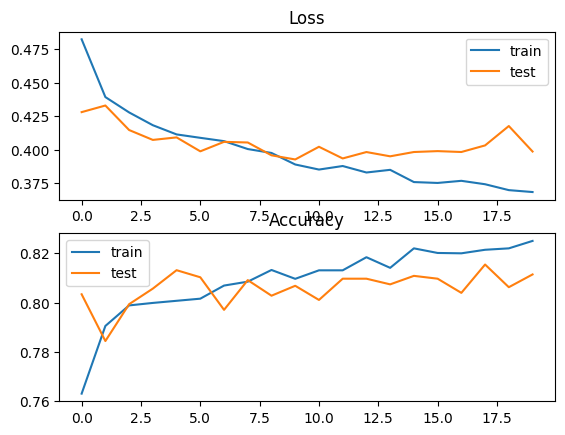

In [27]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Prediction

In [28]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [29]:
test[num_features] = test[num_features].fillna(0)
test[cat_features] = test[cat_features].fillna(method='ffill')

C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\4212349855.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[cat_features] = test[cat_features].fillna(method='ffill')


In [30]:
test['CryoSleep'] = test['CryoSleep'].astype(int)
test["VIP"] = test['VIP'].astype(int)

test['Group'] = test['PassengerId'].apply(lambda x: x.split("_")[0])

test[["Deck", "Cabin_num", "Side"]] = test["Cabin"].str.split("/", expand=True)
test.drop("Cabin", axis=1, inplace=True)

test['HomePlanet'] = test['HomePlanet'].replace(homeplanets)
test['Destination'] = test['Destination'].replace(destinations)
test['Deck'] = test['Deck'].replace(decks)
test['Side'] = test['Side'].replace(sides)

X = test[features]
X = ss.transform(X)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\1216764501.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['HomePlanet'] = test['HomePlanet'].replace(homeplanets)
C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\1216764501.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Destination'] = test['Destination'].replace(destinations)
C:\Users\Manuel\AppData\Local\Temp\ipykernel_23732\1216764501.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain

In [31]:
y_pred = np.round(model.predict(X)).astype(bool).flatten()

  1/134 [..............................] - ETA: 10s

134/134 [==============================] - 0s 1ms/step


In [32]:
submission = pd.DataFrame({"PassengerId": test['PassengerId'].values, "Transported": y_pred})

In [33]:
submission.to_csv("data/submission.csv", index=False)

In [36]:
import joblib

joblib.dump(model,'models/nn_model.pkl')

joblib.dump(ss,'preprocessors/ss_preprocessor.pkl')

['preprocessors/ss_preprocessor.pkl']